# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem defition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
# importing the module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jl
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# importing machine learning module and evaluation metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error

## 5. Modeling
### 5.1 Preprocessing data

In [2]:
# importing the data
df_train_val = pd.read_csv(
    "data/TrainAndValid.csv",
    low_memory=False,
    parse_dates=["saledate"])
df_test = pd.read_csv(
    "data/Test.csv",
    low_memory=False,
    parse_dates=["saledate"])

In [3]:
# check the trin val data
df_train_val.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [5]:
# check test data
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

In [7]:
# create preprocessing function
def preprocess_data(df):
    """
    perform transfromation on df and returns transformed df
    """
    # separaete saledate into multiple colums
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleOfWeek"] = df.saledate.dt.dayofweek
    df["saleOfYear"] = df.saledate.dt.dayofweek

    # drop sale date column
    df.drop("saledate", axis=1, inplace=True)
    
    # fill missing numeric value with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # add a binary column to track if the data is mising
                df[label+"_is_missing"] = pd.isnull(content)
                # fill missing value with median
                df[label] = content.fillna(content.median())   
    # filling and turning categorcical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            # add the binary column to track wich values is missing
            df[label+"_is_missing"] = pd.isnull(content)
            # turn categories into numbers and + 1 (if not +1 the categories codes start wiht -1)
            df[label] = pd.Categorical(content).codes+1
    return df

In [8]:
# convert the string dtype into category dtype
for label, content in df_train_val.items():
    if pd.api.types.is_string_dtype(content):
        df_train_val[label] = content.astype("category").cat.as_ordered()

In [9]:
df_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   category      
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  category      
 11  fiBaseModel               412698 non-null  category      
 12  fi

In [10]:
# preprocess the data
preprocess_data(df_train_val)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,2,963,...,True,True,True,True,True,True,True,True,False,False
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,2,1745,...,True,True,True,True,True,True,True,True,False,False
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,1,336,...,True,True,True,True,True,True,True,True,True,True
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,1,3716,...,True,True,True,True,True,True,True,True,True,True
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,3,4261,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6333344,10000.0,1919201,21435,149,2.0,2005,0.0,0,490,...,False,False,False,False,False,True,True,True,True,True
412694,6333345,10500.0,1882122,21436,149,2.0,2005,0.0,0,491,...,False,False,False,False,False,True,True,True,True,True
412695,6333347,12500.0,1944213,21435,149,2.0,2005,0.0,0,490,...,False,False,False,False,False,True,True,True,True,True
412696,6333348,10000.0,1794518,21435,149,2.0,2006,0.0,0,490,...,False,False,False,False,False,True,True,True,True,True


In [11]:
# check the data
df_train_val.info(), df_train_val[:53].isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


(None,
 SalesID                         0
 SalePrice                       0
 MachineID                       0
 ModelID                         0
 datasource                      0
                                ..
 Backhoe_Mounting_is_missing     0
 Blade_Type_is_missing           0
 Travel_Controls_is_missing      0
 Differential_Type_is_missing    0
 Steering_Controls_is_missing    0
 Length: 103, dtype: int64)

In [12]:
# sorting the test and train data by saleyear
df_train_val.sort_values(by=["saleYear"], inplace=True, ascending=True)
df_train_val.saleYear.head(10)

78771     1989
140253    1989
78621     1989
140257    1989
78620     1989
78614     1989
78611     1989
78605     1989
78551     1989
78544     1989
Name: saleYear, dtype: int64

In [13]:
# preprocessing test data
preprocess_data(df_test)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True


In [14]:
# check is there any different between dataframe
set(df_train_val.columns) - set(df_test.columns)

{'SalePrice', 'auctioneerID_is_missing'}

In [15]:
# add auctioneerIDis_missing column to test data set
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


### 5.2 visualize the data

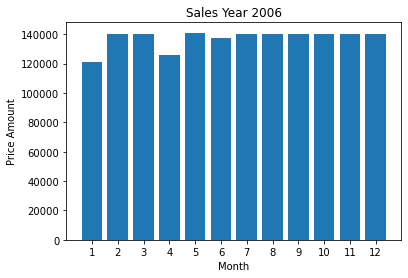

In [16]:
year_2006 = df_train_val[df_train_val.saleYear == 2006]

# visualize sumary sales price by the year 2006
fig, ax = plt.subplots()
ax.bar(year_2006.saleMonth, year_2006.SalePrice)
ax.set(
    title="Sales Year 2006",
    xlabel="Month",
    ylabel="Price Amount",
    xticks=np.arange(1,13,1)
      );

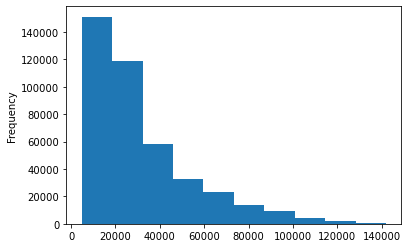

In [17]:
df_train_val.SalePrice.plot.hist();

### 5.3 fitting the data into the model

In [18]:
%%time
# drop _is_missing columns
df_train_val.drop(df_train_val.columns[57:], axis=1, inplace=True)
df_test.drop(df_test.columns[56:], axis=1, inplace=True)

# split the data into training set and validation set
df_val = df_train_val[df_train_val.saleYear == 2012]
df_train = df_train_val[df_train_val.saleYear != 2012]

# cretae x and y
x_train = df_train.drop("SalePrice", axis=1)
y_train = df_train["SalePrice"]
x_valid = df_val.drop("SalePrice", axis=1)
y_valid = df_val["SalePrice"]

# # instantiate the model
# model = RandomForestRegressor(
#     n_jobs=-1,
#     random_state=42        
# )

# # fit the data into the model
# model.fit(x_train, y_train)

Wall time: 572 ms


### 5.4 Evaluation metrics

In [32]:
# create evaluation functions (MSE= percentage different, mae=value different)
def rmsle(y_test, y_preds):
    """
    calculate root mean squared error between 
    predictions and true label
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# cretae function to evaluate model on a few different levels
def show_score(model):
    """
    Return evaluation model on different level
    """
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_valid)
    scores = {
        "Training MAE": mean_absolute_error(y_train, train_preds),
        "valid MAE": mean_absolute_error(y_valid, val_preds),
        "Training RMSLE": rmsle(y_train, train_preds),
        "valid RMSLE": rmsle(y_valid, val_preds),
        "Training R^2": r2_score(y_train, train_preds),
        "Valid R^2": r2_score(y_valid, val_preds)
    }
    return scores

In [20]:
# check scoring base model
show_score(model)

{'Training MAE': 1582.5767201246492,
 'valid MAE': 6074.50101443014,
 'Training RMSLE': 0.08418193492505109,
 'valid RMSLE': 0.25243981030711293,
 'Training R^2': 0.9874968236047259,
 'Valid R^2': 0.8741391200308035}

### 5.5 tuning hyperparameters model with RandomizeSearchCV

In [231]:
%%time
from sklearn.model_selection import RandomizedSearchCV
# cretae grid hyperparameters model
rs_grid = {
    "n_estimators": np.arange(10,100,10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [0.5, 1, "sqrt", "auto"],
    "max_samples": [10000]
}

# instantiate the model
rs_model = RandomizedSearchCV(
                RandomForestRegressor(
                        n_jobs=-1,
                        random_state=42),
            param_distributions=rs_grid,
            n_iter=100,
            cv=5,
            verbose=True)

# fit data to the model
rs_model.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 31min 20s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [232]:
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [234]:
show_score(rs_model)

{'Training MAE': 5657.753548852186,
 'valid MAE': 7601.530115594728,
 'Training RMSLE': 0.2612776747205812,
 'valid RMSLE': 0.30061907131983695,
 'Training R^2': 0.8577587813438963,
 'Valid R^2': 0.8080478909973684}

### 5.6 fitting the model with best hyperparameters

In [24]:
%%time
# instantiate the model
model_1 = RandomForestRegressor(
                n_estimators= 40,
                min_samples_split= 14,
                min_samples_leaf= 1,
                max_samples= None,
                max_features= 0.5,
                max_depth= None)

# fit the data
model_1.fit(x_train, y_train)

Wall time: 2min 58s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40)

In [25]:
show_score(model_1)

{'Training MAE': 2997.549112600361,
 'valid MAE': 5922.540310356244,
 'Training RMSLE': 0.14621546758887166,
 'valid RMSLE': 0.24452762594276725,
 'Training R^2': 0.9577539890312216,
 'Valid R^2': 0.8823044179735893}

In [26]:
%%time
# instantiate the model
model_2 = RandomForestRegressor(
                n_estimators= 40,
                min_samples_split= 2,
                min_samples_leaf= 1,
                max_samples= None,
                max_features= 0.5,
                max_depth= None)

# fit the data
model_2.fit(x_train, y_train)

Wall time: 3min 47s


RandomForestRegressor(max_features=0.5, n_estimators=40)

In [27]:
show_score(model_2)

{'Training MAE': 1617.3794091201835,
 'valid MAE': 5956.076077940033,
 'Training RMSLE': 0.08607873765757053,
 'valid RMSLE': 0.2458589203679183,
 'Training R^2': 0.9869408574577799,
 'Valid R^2': 0.8805953693812476}

In [123]:
%%time
# instantiate the model
model_3 = RandomForestRegressor(
                n_estimators= 40,
                min_samples_split= 6,
                min_samples_leaf= 1,
                max_samples= None,
                max_features= 0.5,
                max_depth= None)

# fit the data
model_3.fit(x_train, y_train)

Wall time: 3min 25s


RandomForestRegressor(max_features=0.5, min_samples_split=6, n_estimators=40)

In [124]:
show_score(model_3)

{'Training MAE': 2153.7535640005917,
 'valid MAE': 5948.740668118731,
 'Training RMSLE': 0.1106226984842218,
 'valid RMSLE': 0.2456383369760817,
 'Training R^2': 0.9772044396065914,
 'Valid R^2': 0.8817205488378279}

* comparing the models

In [41]:
model_comparasion = pd.DataFrame(
    [show_score(model), 
    show_score(model_1),
    show_score(model_2)],
    index=["base_model", "model_1", "model_2"])
model_comparasion

,Training MAE,valid MAE,Training RMSLE,valid RMSLE,Training R^2,Valid R^2
base_model,1582.576720,6074.501014,0.084182,0.252440,0.987497,0.874139
model_1,2997.549113,5922.540310,0.146215,0.244528,0.957754,0.882304
model_2,1617.379409,5956.076078,0.086079,0.245859,0.986941,0.880595


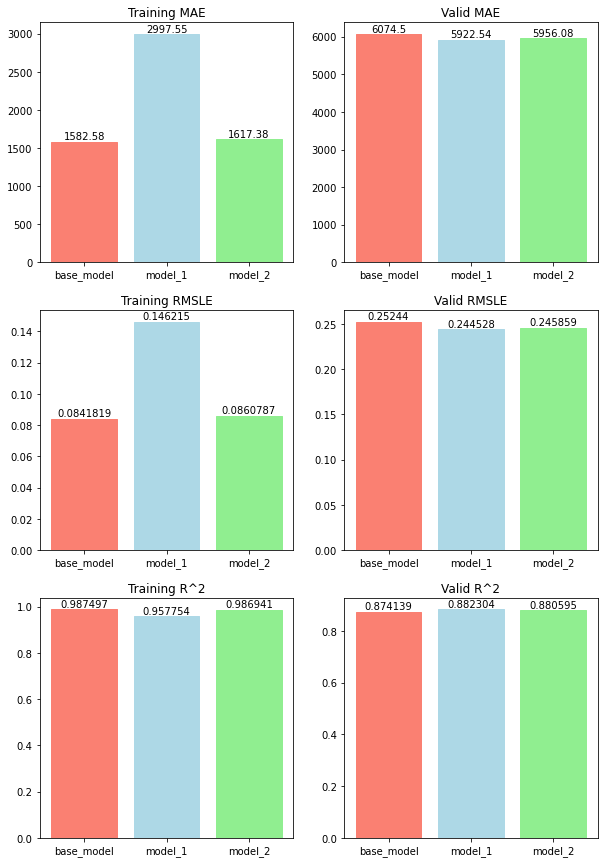

In [114]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,15))
ax[0,0].bar(model_comparasion.T.columns , list(model_comparasion["Training MAE"].values))
ax[0,0].set(title="Training MAE")
ax[0,0].bar_label(ax[0,0].containers[0])
ax[0,0].get_children()[0].set_color('salmon')
ax[0,0].get_children()[1].set_color('lightblue')
ax[0,0].get_children()[2].set_color('lightgreen')

ax[0,1].bar(model_comparasion.T.columns , list(model_comparasion["valid MAE"].values))
ax[0,1].set(title="Valid MAE")
ax[0,1].bar_label(ax[0,1].containers[0])
ax[0,1].get_children()[0].set_color('salmon')
ax[0,1].get_children()[1].set_color('lightblue')
ax[0,1].get_children()[2].set_color('lightgreen')

ax[1,0].bar(model_comparasion.T.columns , list(model_comparasion["Training RMSLE"].values))
ax[1,0].set(title="Training RMSLE")
ax[1,0].bar_label(ax[1,0].containers[0])
ax[1,0].get_children()[0].set_color('salmon')
ax[1,0].get_children()[1].set_color('lightblue')
ax[1,0].get_children()[2].set_color('lightgreen')

ax[1,1].bar(model_comparasion.T.columns , list(model_comparasion["valid RMSLE"].values))
ax[1,1].set(title="Valid RMSLE")
ax[1,1].bar_label(ax[1,1].containers[0])
ax[1,1].get_children()[0].set_color('salmon')
ax[1,1].get_children()[1].set_color('lightblue')
ax[1,1].get_children()[2].set_color('lightgreen')

ax[2,0].bar(model_comparasion.T.columns , list(model_comparasion["Training R^2"].values))
ax[2,0].set(title="Training R^2")
ax[2,0].bar_label(ax[2,0].containers[0])
ax[2,0].get_children()[0].set_color('salmon')
ax[2,0].get_children()[1].set_color('lightblue')
ax[2,0].get_children()[2].set_color('lightgreen')

ax[2,1].bar(model_comparasion.T.columns , list(model_comparasion["Valid R^2"].values))
ax[2,1].set(title="Valid R^2")
ax[2,1].bar_label(ax[2,1].containers[0])
ax[2,1].get_children()[0].set_color('salmon')
ax[2,1].get_children()[1].set_color('lightblue')
ax[2,1].get_children()[2].set_color('lightgreen')

### 5.7 make predcitions on test data set

In [28]:
test_preds = model_1.predict(df_test)
# format predictions into the same fromat kaggle request
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds.head()

,SalesID,SalesPrice
0,1227829,16529.943804
1,1227844,17234.360254
2,1227847,47687.348321
3,1227848,62429.894107
4,1227863,54623.262455


In [138]:
# create function to plot feature importance
def plot_features(columns, importances, n=57):
    df = (pd.DataFrame({
            "features": columns,
            "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    fig, ax = plt.subplots(figsize=(10,20))
    ax = sns.barplot(
            x="feature_importances",
            y="features",
            data=df[:n],
            orient="h"
    )
    ax.bar_label(ax.containers[0])
#     sns.set(rc = {'figure.figsize':(10,20)})

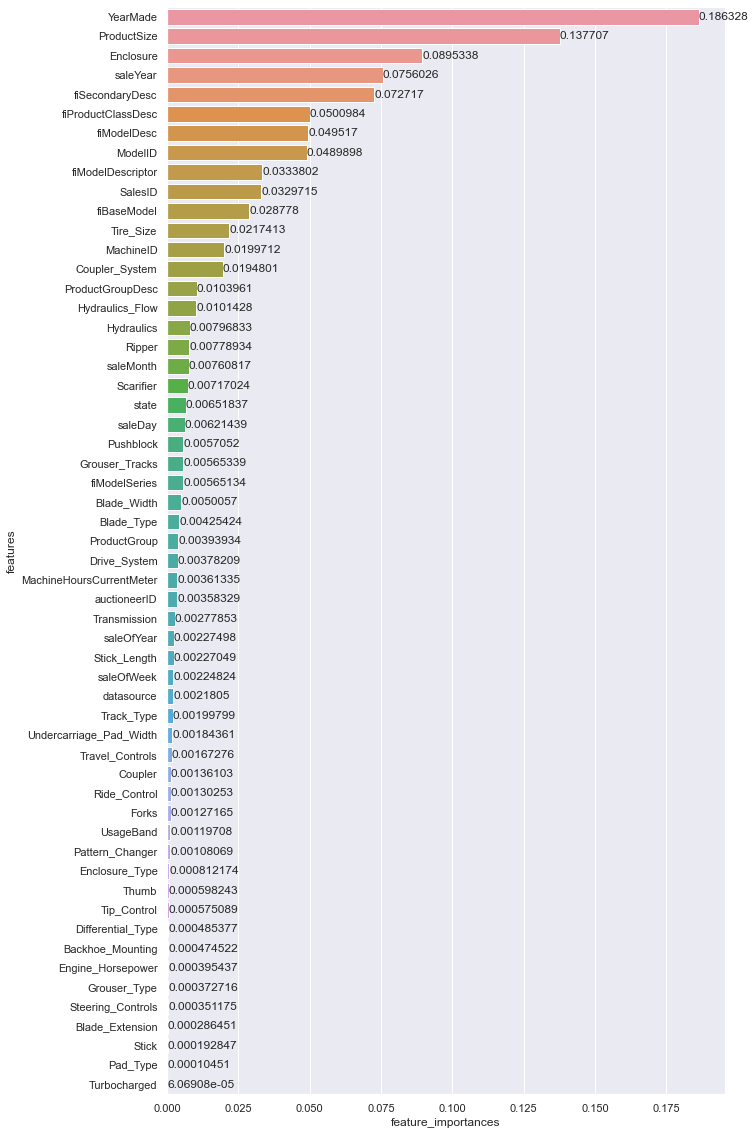

In [139]:
plot_features(x_train.columns, model_1.feature_importances_)

# Final model

In [4]:
%%time
# importing the module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jl

# importing machine learning module and evaluation metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error

# setup random seed
np.random.seed(42)

# importing the data
df_train_val = pd.read_csv(
    "data/TrainAndValid.csv",
    low_memory=False,
    parse_dates=["saledate"])
df_test = pd.read_csv(
    "data/Test.csv",
    low_memory=False,
    parse_dates=["saledate"])

# create preprocessing function
def preprocess_data(df):
    """
    perform transfromation on df and returns transformed df
    """
    # separaete saledate into multiple colums
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleOfWeek"] = df.saledate.dt.dayofweek
    df["saleOfYear"] = df.saledate.dt.dayofweek

    # drop sale date column
    df.drop("saledate", axis=1, inplace=True)
    
    # fill missing numeric value with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # add a binary column to track if the data is mising
                df[label+"_is_missing"] = pd.isnull(content)
                # fill missing value with median
                df[label] = content.fillna(content.median())   
    # filling and turning categorcical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            # add the binary column to track wich values is missing
            df[label+"_is_missing"] = pd.isnull(content)
            # turn categories into numbers and + 1 (if not +1 the categories codes start wiht -1)
            df[label] = pd.Categorical(content).codes+1
    return df

# preprocess the data
preprocess_data(df_test)
preprocess_data(df_train_val)

# crating preprocessing and modeling pipeline
model = RandomForestRegressor(
              n_estimators= 40,
              min_samples_split= 2,
              min_samples_leaf= 1,
              max_samples= None,
              max_features= 0.5,
              max_depth= None,
              n_jobs=-1,
              random_state=42)

# drop _is_missing columns
df_train_val.drop(df_train_val.columns[57:], axis=1, inplace=True)
df_test.drop(df_test.columns[56:], axis=1, inplace=True)

# split the data into training set and validation set
df_val = df_train_val[df_train_val.saleYear == 2012]
df_train = df_train_val[df_train_val.saleYear != 2012]

# cretae x and y
x_train = df_train.drop("SalePrice", axis=1)
y_train = df_train["SalePrice"]
x_valid = df_val.drop("SalePrice", axis=1)
y_valid = df_val["SalePrice"]

# fit the model
model.fit(x_train, y_train)

# create evaluation functions (MSE= percentage different, mae=value different)
def rmsle(y_test, y_preds):
    """
    calculate root mean squared error between 
    predictions and true label
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# cretae function to evaluate model on a few different levels
def show_score(model):
    """
    Return evaluation model on different level
    """
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_valid)
    scores = {
        "Training MAE": mean_absolute_error(y_train, train_preds),
        "valid MAE": mean_absolute_error(y_valid, val_preds),
        "Training RMSLE": rmsle(y_train, train_preds),
        "valid RMSLE": rmsle(y_valid, val_preds),
        "Training R^2": r2_score(y_train, train_preds),
        "Valid R^2": r2_score(y_valid, val_preds)
    }
    return scores

# check score model
show_score(model)

Wall time: 1min 13s


{'Training MAE': 1614.427414521658,
 'valid MAE': 5963.878156052882,
 'Training RMSLE': 0.08600116062733816,
 'valid RMSLE': 0.24525630033554827,
 'Training R^2': 0.9869662190431222,
 'Valid R^2': 0.8810124955893445}

In [9]:
# Format predictions into the same format Kaggle is after
test_preds = model.predict(df_test)
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds

# Export prediction data
df_preds.to_csv("data/test_predictions.csv", index=False)

# save module with joblib
jl.dump(model, filename="Bulldozer-Model.joblib")

df_preds

,SalesID,SalesPrice
0,1227829,16235.00
1,1227844,15247.50
2,1227847,51100.00
3,1227848,62662.50
4,1227863,51682.50
...,...,...
12452,6643171,49575.00
12453,6643173,13983.75
12454,6643184,13465.00
12455,6643186,18925.00
